# Analyze red noise in one pulsar

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import config, jit, vmap
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as js

import numpyro
import numpyro.distributions as dist

# use double precision
config.update('jax_enable_x64', True)

import sys
import os
sys.path.append(os.path.abspath('..'))

from PTA import PTA
from likelihood import get_likelihood_obj
from samples import Samples

%load_ext autoreload
%autoreload 2

## Simulate data

In [2]:
# make PTA detector and model
pta = PTA(Np=1,  # number of pulsars
          Tspan_yr=15.,  # observation time span
          Nf=30,  # number of frequency bins to inject / model
          model_wn=False,  # model white noise (EFAC)
          model_rn=False,  # model intrinsic pulsar red noise
          model_gwb=True,  # model gravitational wave background
          model_cw=False,  # model continuous wave
          efacs_inj=jnp.array([1.0]),  # injected EFAC value
          gwb_power_law_inj=jnp.array([-13.4, 3.2]),  # injected power law parameters
          seed=0,  # random seed for simulation
          )

# likelihood object
l = get_likelihood_obj(pta)

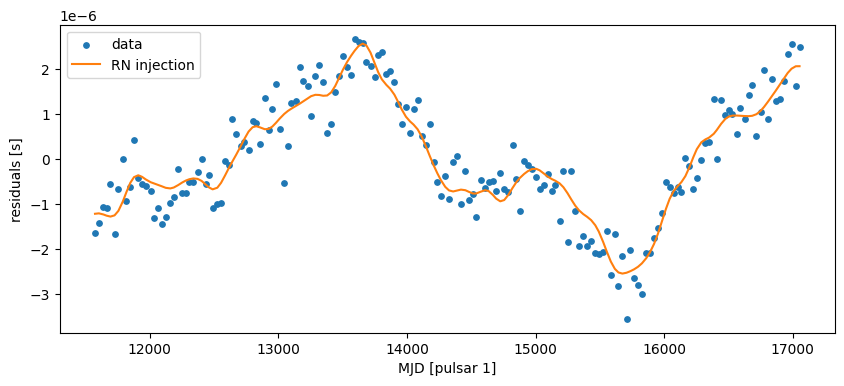

In [3]:
# plot data and injected signals
psr_ndx = 0
plt.figure(figsize=(10, 4))
plt.scatter(pta.MJDs[psr_ndx], pta.residuals[psr_ndx], color='C0', s=15, label='data')
rn_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
plt.plot(pta.MJDs[psr_ndx], rn_residuals_inj, color='C1', label='RN injection')
plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.show()

## Sample posterior

In [4]:
# kernel
def sampling_model():
    # uniform prior on hyper-parameters
    rn_hypers = numpyro.sample('rn_hypers', dist.Uniform(pta.gwb_mins, pta.gwb_maxs))

    # normal prior on Fourier coefficients
    a_standard = numpyro.sample('a_standard', dist.Normal().expand([pta.Na]))
    a_transformed = jnp.sqrt(pta.get_rho_diag(rn_hypers)) * a_standard
    a = numpyro.deterministic('a', a_transformed)

    # likelihood
    numpyro.factor('ln_likelihood', l.lnlike(pta.efacs_inj, a))

In [5]:
# sample with NumPyro NUTS
nuts_kernel = numpyro.infer.NUTS(sampling_model,
                                 dense_mass=True)
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e4),
                          num_samples=int(1e6))
mcmc.run(jr.key(11))
samples_dict = mcmc.get_samples()

sample: 100%|██████████| 1010000/1010000 [05:56<00:00, 2832.03it/s, 31 steps of size 1.63e-01. acc. prob=0.83]


## Post-processing

In [12]:
# rewrite Fourier coefficient labels for one pulsar
a_labels_one_psr = np.array([rf'$a^R_{{{j // 2}}}$' if j % 2 == 0 else \
                             rf'$b^R_{{{j // 2}}}$'
                             for j in range(2, pta.Na + 2)])

# rewrite hyper-parameter labels for one pulsar
hyper_labels = np.array([r'$\log_{{{10}}}\,A$', r'$\gamma$'])

# convert samples dictionary into numpy array
samples_arr = np.concatenate((samples_dict['rn_hypers'],
                              samples_dict['a'],
                              ), axis=1)

# make samples object for post-processing
samples = Samples(samples_arr=samples_arr,
                  labels=np.concatenate((hyper_labels, a_labels_one_psr)),
                  x_inj=pta.x_inj)

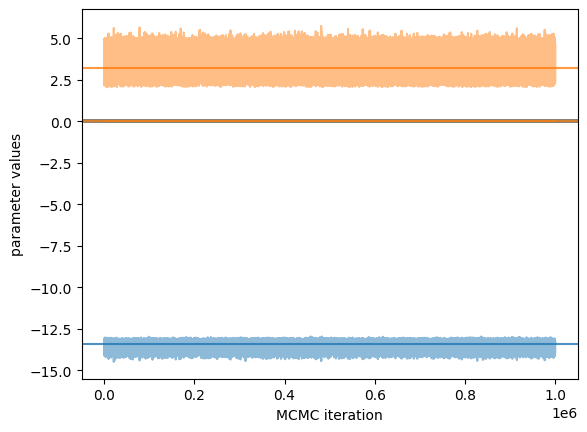

In [13]:
# plot parameter values over MCMC samples
samples.trace_plt(legend=False)

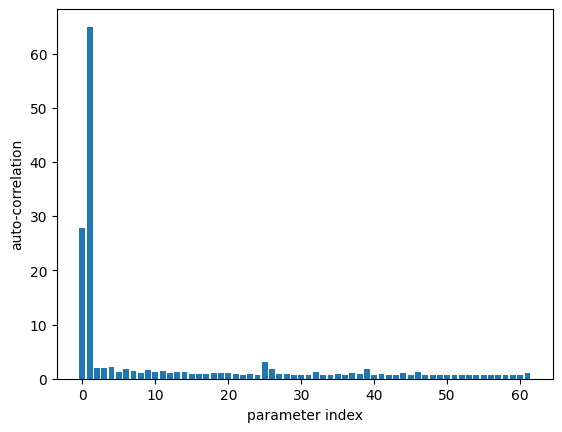

In [14]:
# plot auto-correlation length of parameters
samples.plt_auto_corr()

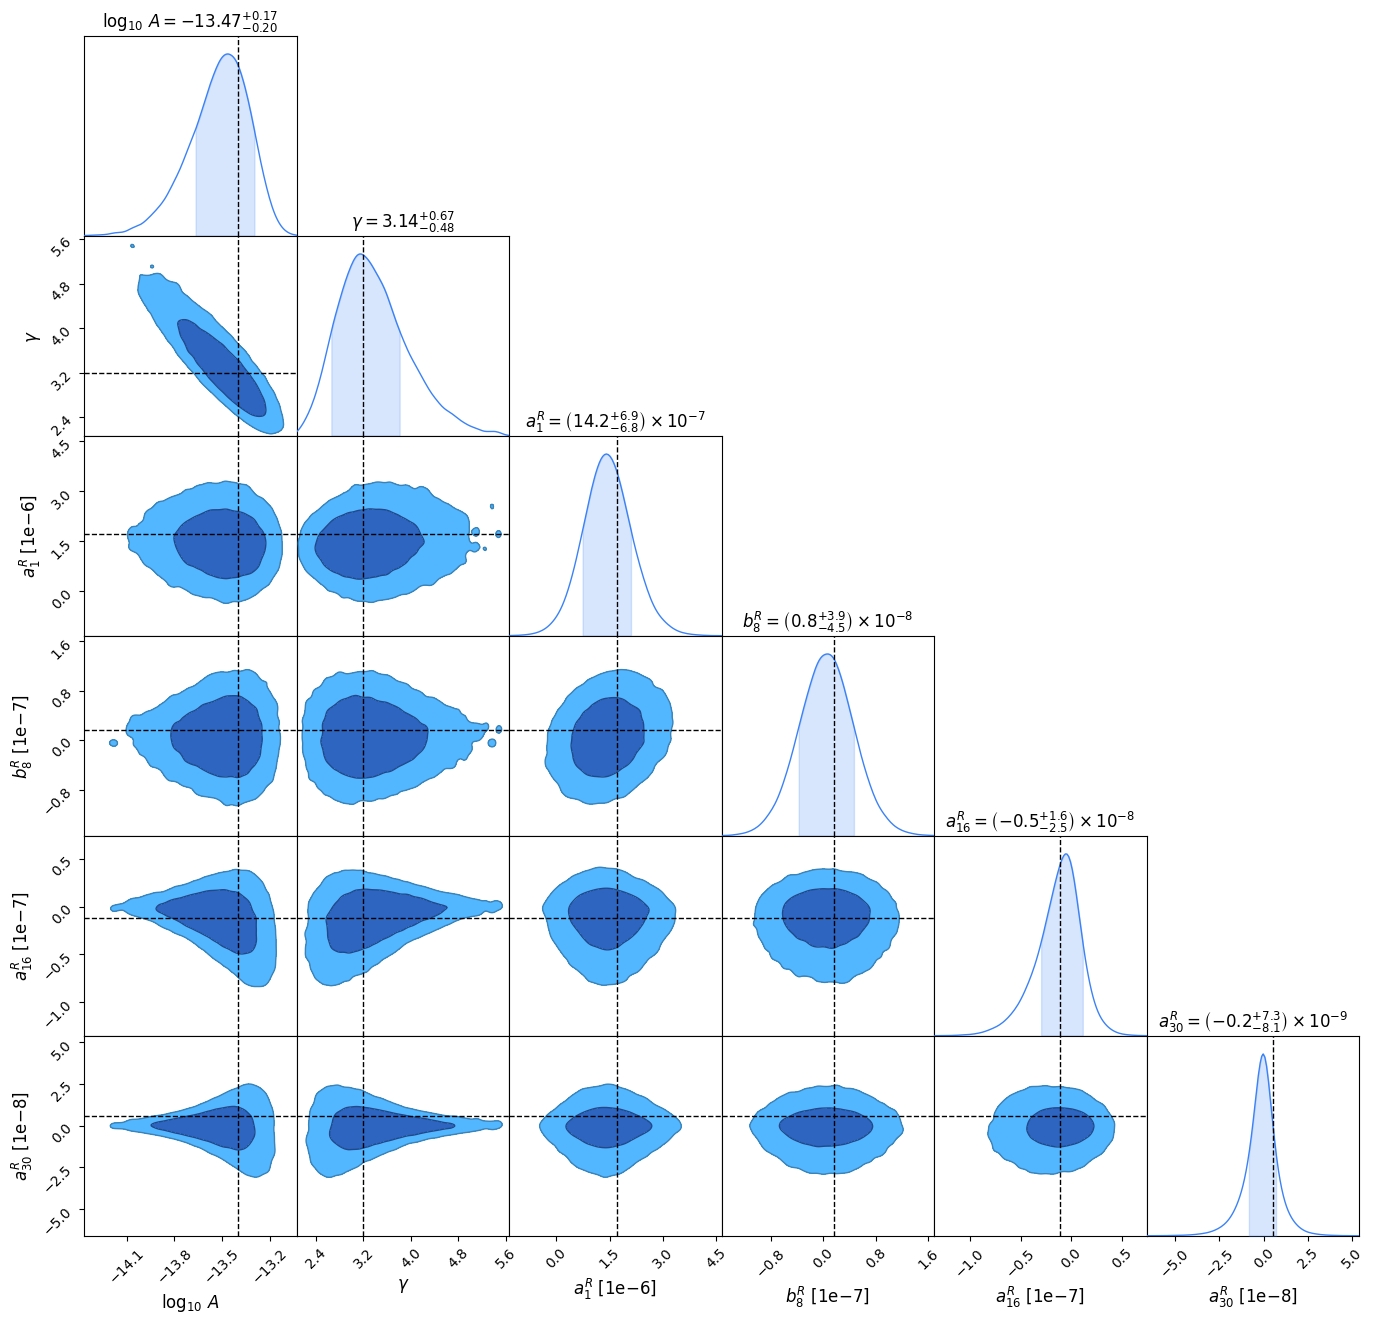

In [15]:
# indices of parameters to plot
ndxs = np.concatenate((pta.gwb_ndxs,
                       pta.a_ndxs[:1],
                       pta.a_ndxs[15:16],
                       pta.a_ndxs[30:31],
                       pta.a_ndxs[-2:-1]))

# corner plot
samples.corner_plt(param_ndxs=ndxs, thin=10, burnin=0, color='blue')

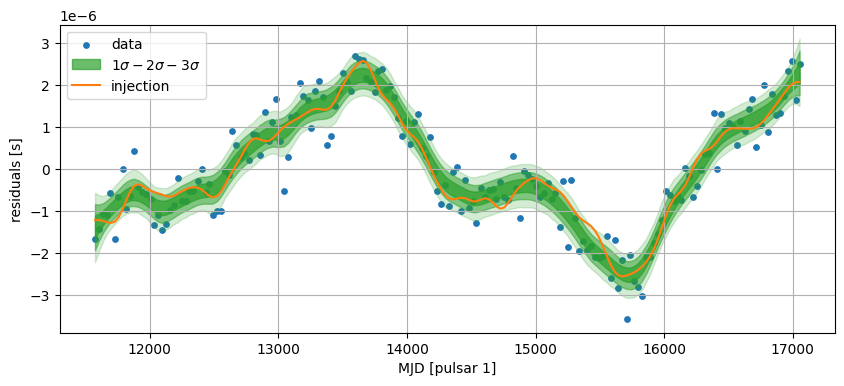

In [16]:
# Bayesogram
psr_ndx = 0
fair_draw_ndxs = np.random.choice(samples_arr.shape[0], (10_000,))

# percentile layers for plotting densities of samples
percentile_layers = [0.15, 2.5, 16.]
# percentile_layers = [0.01, 0.15, 16.]
alphas = [0.2, 0.5, 0.7]

# plot data, samples, and injected signals
plt.figure(figsize=(10, 4))
plt.scatter(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ pta.residuals[psr_ndx], color='C0', s=15, label='data')

rn_gwb_signals = np.array([pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ samples_arr[ndx, pta.a_ndxs].reshape((pta.Np, pta.Na))[psr_ndx]
                           for ndx in fair_draw_ndxs])
for percentile, alpha in zip(percentile_layers, alphas):
    if percentile != percentile_layers[-1]:
        plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                        np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                        color='C2', alpha=alpha)
    else:
        plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                        np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                        color='C2', alpha=alpha, label=r'$1\sigma-2\sigma-3\sigma$')
rn_gwb_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
plt.plot(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ rn_gwb_residuals_inj, color='C1', label='injection')

plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.grid()
plt.show()

In [17]:
np.save('hyper_samples.npy', samples.samples[:, pta.gwb_ndxs])